# Food UK - Logistic Regression

- _Author_: Lucas Gonzalez Santa Cruz
- _Workshop_: Data Science Intensive, Springboard.com
- _Date_: 3 October 2016

# tl;dr

_In the UK, since 1974, several thousands of families are selected each year (different families each year). Data is collected about **each family** (about 50 variables: place, number of members of different ages, socioeconomic variables), and about **what each family buys over one week** (3 pints of skimmed milk, 2 pounds sterling; etc). Food items ("brown bread") are categorised into food groups ("breads"). For each food item, 47 **nutrients** are known (calories, vitamin D, etc)._

_I'm interested in food generally, but for this project I will only:_
- _define a score of "shopping-cart goodness" (more fruit+vegs than junk food)_
- _look at how some family variables (income, location, etc) predict a "good cart"_

# Table of Contents
* [Motivation and goals](#1.-Motivation-and-goals)
* [Data source and datasets](#2.-Data-source-and-datasets)
* [Data wrangling](#3.-Data-wrangling)
    * [Initial settings](#Initial-settings)
    * [Foods, groups and units](#Foods,-groups-and-units)
    * [Weekly food purchases](#Weekly-food-purchases)
    * [Families and their variables](#Families-and-their-variables)
* [Modeling](#4.-Modeling)
    * [Score for good-cart](#Score-for-good-cart)
    * [Categories](#Categories)
    * [Logistic regression](#Logistic-regression)
* [Discussion](#5.-Discussion)

# 1. Motivation and goals

Food is interesting for many inter-related reasons: food security (poverty, climate change and pandemic disruption), nutritional health ("blue zones"), ecological reasons (edible forests), economic developement (jobs), data and automation (mapping images of fields to help agricultural producers).

Here I'll use one particular dataset with the intention of learning to use at least one machine language procedure (Logistic Regression). I will look at what types of food are bought by UK families, and attempt to see how some of their demographic variables "predict" how healthy is their weekly shopping.

# 2. Data source and datasets

UK families (a different sample each year for many years), have been asked what food they buy for a week.

Data between 1974-2000 is open data:
* Available at http://britains-diet.labs.theodi.org
* Datasets:
    * Households: a file with a line per household, and for each of them 53 variables: number of female adults, male adults and children; income; location; etc. Also, many files translating codes to literals: 11=Scotland, 1=household owner is female, etc.
    * Purchases: a file with a line per food item bought: a certain household bought, over the course of a week, 6 loaves of brown bread (money paid), 3 pints of skimmed milk (money paid), etc.
    * Food groups: several files that put the 300+ food items ("milk", "cheese") into 20+ food groups ("milky products").
    * Nutrients: for each food item (and even for 4 "seasons" each year) there's information about 47 nutrients (calories, vitamin D, etc).

(Data since 2001 is published only in summarised form. We won't be using it here.)

I collected the files manually and placed it in one folder for convenience.

# 3. Data wrangling

* We want one line per household.
* Household variables: household identifier, year, and the other 50+ variables.
* Also for each household: how much of each food they bought.

## Initial settings

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm

import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

import numpy as np
import scipy as sp

from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

In [2]:
#http://data.defra.gov.uk/Food/NationalFoodSurvey/NFSopen_2000.zip (etc for all years)
#http://data.defra.gov.uk/Food/NationalFoodSurvey/NFSopen_Reference.zip
data = 'data/'
data2000 = 'data/NFSopen_2000/'
dataRefe = 'data/NFSopen_Reference/'

## Foods, groups and units

There are several files describing the food codes, groups, and units.

Essentially, there are 315 food codes (each measured in pints or grams etc), grouped into 24 group. Each group has between 1 and 50 different foods.

In [3]:
#315 detailed "minor" foodcodes ...
df_min_maj = pd.DataFrame.from_csv(dataRefe+'Ref_ Minor and major foods.txt', sep='\t', index_col=None)
df_min_maj.columns=['minor', 'minor_text', 'major']

#... then aggregated into 184 "major" groups.
df_maj_text = pd.DataFrame.from_csv(dataRefe+'Ref_ Major food codes.txt', sep='\t', index_col=None)
df_maj_text.columns=['major', 'major_text']

#24 more aggregated "groups" were defined, and the 183 previous "detailed groups" were mapped to these 24.
df_grp_text = pd.DataFrame.from_csv(dataRefe+'Ref_ food groups (standard).txt', sep='\t', index_col=None)
df_grp_text.columns=['group','group_text']

#A "mapping" file with 596 rows ...
df_mapping = pd.DataFrame.from_csv(dataRefe+'Ref_ Major-food group mapping.txt', sep='\t', index_col=None)
df_mapping.columns=['major','group']

#... had 92 groups, and those 24 had to be selected.
group24 = [4006, 9017, 22023, 31041, 46094, 100127, 129129, 135148, 150154, 155161, 162171, 172183, \
           184208, 210231, 233248, 251263, 264264, 267277, 281301, 304313, 314339, 340344, 350354, 380389]
df_maj_group = df_mapping[df_mapping['group'].isin(group24) == True] #shape 183x2

In [4]:
#Each "foodcode" (all 315 of them) is described with one of 7 "units": pints, ounces, etc.
df_min_units = pd.DataFrame.from_csv(dataRefe+'Ref_MINFD_Minor_food_codes.txt', sep='\t', index_col=None)
df_min_units.columns=['minor','minor_text','units']
df_min_units.drop(['minor_text'], inplace=True, axis=1) #to avoid duplicate later

In [5]:
# ===== df_groups 315 groups x 6 fields: minor, minor_text, major, major_text, group, group_text
df = pd.merge(df_min_maj, df_maj_text, how='left', on='major')
df = pd.merge(df, df_maj_group, how='left', on='major')
df = pd.merge(df, df_grp_text, how='left', on='group')
df_groups = df

In [6]:
print len(df), "food items, each with", len(df.columns)," variables:", list(df.columns.values)

315 food items, each with 6  variables: ['minor', 'minor_text', 'major', 'major_text', 'group', 'group_text']


In [7]:
#print "\nThe 24 food-groups each have a different number of food-items:"
#df.groupby('group_text').minor.nunique()
print "And each group may have foods of very different nutritional quality:"
df = df_groups
list_of_groups = df.group_text.unique()
for g in list_of_groups:
    list_of_foods = df[df.group_text == g].minor_text
    print "\nGroup", g, "has", len(list_of_foods), "different foods:", "\n", list_of_foods.as_matrix()

And each group may have foods of very different nutritional quality:

Group LIQUID WHOLEMILK, INC SCHOOL & WELFARE has 6 different foods: 
['MILK  LIQUID  FULL PRICE' 'UHT LIQUID MILK, FULL PRICE'
 'STERILISED MILK, FULL PRICE' 'OTHER LIQUID MILK, FULL PRICE'
 'MILK  LIQUID  WELFARE' 'MILK  LIQUID  SCHOOL']

Group OTHER MILK & CREAM has 14 different foods: 
['MILK  CONDENSED' 'MILK  DRIED  NATIONAL' 'INFANT MILKS' 'MILK  INSTANT'
 'YOGHURT' 'FROMAGE FRAIS' 'SKIMMED MILK' 'FULLY SKIMMED MILK'
 'SEMI AND OTHER SKIMMED MILKS' 'OTHER MILK, INC SKIMMED'
 'OTHER MILK, NOT SKIMMED' 'DAIRY DESSERTS' 'OTHER MILKS' 'CREAM']

Group TOTAL CHEESE has 7 different foods: 
['CHEESE NAT HARD CHEDDAR AND CHEDDAR TYPE'
 'CHEESE NAT HARD OTHER UK VAR & FOR EQUIV'
 'CHEESE NAT HARD EDAM & OTHER CONTINENTAL' 'CHEESE NATURAL SOFT'
 'COTTAGE CHEESE' 'OTHER CHEESE NATURAL SOFT' 'CHEESE PROCESSED']

Group ALL CARCASE MEAT has 17 different foods: 
['BEEF STEAK INCL STEWING AND STK & KIDNEY'
 'BEEF JOINTS ON THE 

## Weekly food purchases

In [8]:
df_purc1995 = pd.DataFrame.from_csv(data+'1995 diary data.txt', sep='\t', index_col=None)
df_purc1995['survyear'] = '1995'
df_purc1996 = pd.DataFrame.from_csv(data+'1996 diary data.txt', sep='\t', index_col=None)
df_purc1996['survyear'] = '1996'
df_purc1997 = pd.DataFrame.from_csv(data+'1997 diary data.txt', sep='\t', index_col=None)
df_purc1997['survyear'] = '1997'
df_purc1998 = pd.DataFrame.from_csv(data+'1998 diary data.txt', sep='\t', index_col=None)
df_purc1998['survyear'] = '1998'
df_purc1999 = pd.DataFrame.from_csv(data+'1999 diary data.txt', sep='\t', index_col=None)
df_purc1999['survyear'] = '1999'
df_purc2000 = pd.DataFrame.from_csv(data+'2000 diary data.txt', sep='\t', index_col=None)
df_purc2000['survyear'] = '2000'
list_of_years = [df_purc1995, df_purc1996, df_purc1997, df_purc1998, df_purc1999, df_purc2000]
df = pd.concat(list_of_years)
df.columns=['hhno', 'fooditem', 'logday', 'purchasevalue', 'minor', 'quantity', 'purchasefree', 'survyear']
df_diary8 = df

# ===== idem + adding "_text", "group" and "unit" variables
df = pd.merge(df_diary8, df_min_maj, how='left', on='minor')
df = pd.merge(df, df_min_units, how='left', on='minor')
df = pd.merge(df, df_maj_text, how='left', on='major')
df = pd.merge(df, df_maj_group, how='left', on='major')
df = pd.merge(df, df_grp_text, how='left', on='group')

# ===== DIARY WITH 14, 10 or 6 VARIABLES
df_diary14 = df
df_diary10 = df[['survyear', 'hhno', 'quantity', 'units', 'minor_text', \
                 'group_text', 'minor', 'major', 'major_text', 'group']]
df_diary6  = df[['survyear', 'hhno', 'minor_text', 'quantity', 'units', 'group_text']]

df = df_diary14
print "DIARY ENTRIES: in 1995-2000, {0:4} families bought {1:6} items, {2:3} foods in {3:2} groups.".\
    format(len(df.hhno.unique()), len(df), len(df.minor_text.unique()), len(df.group_text.unique()))
print len(df.columns), "variables:", list(df.columns.values)

DIARY ENTRIES: in 1995-2000, 42960 families bought 1581381 items, 243 foods in 24 groups.
14 variables: ['hhno', 'fooditem', 'logday', 'purchasevalue', 'minor', 'quantity', 'purchasefree', 'survyear', 'minor_text', 'major', 'units', 'major_text', 'group', 'group_text']


## Families and their variables

In [9]:
df_hous1995 = pd.DataFrame.from_csv(data+'1995 household data.txt', sep='\t', index_col=None)
df_hous1995['survyear'] = '1995'
df_hous1996 = pd.DataFrame.from_csv(data+'1996 household data.txt', sep='\t', index_col=None)
df_hous1996['survyear'] = '1996'
df_hous1997 = pd.DataFrame.from_csv(data+'1997 household data.txt', sep='\t', index_col=None)
df_hous1997['survyear'] = '1997'
df_hous1998 = pd.DataFrame.from_csv(data+'1998 household data.txt', sep='\t', index_col=None)
df_hous1998['survyear'] = '1998'
df_hous1999 = pd.DataFrame.from_csv(data+'1999 household data.txt', sep='\t', index_col=None)
df_hous1999['survyear'] = '1999'
df_hous2000 = pd.DataFrame.from_csv(data+'2000 household data.txt', sep='\t', index_col=None)
df_hous2000['survyear'] = '2000'

list_of_years = [df_hous1995, df_hous1996, df_hous1997, df_hous1998, df_hous1999, df_hous2000]
df = pd.concat(list_of_years)
print "Number of households:", len(df) #len(df.columns), list(df.columns.values) #minor inconsistency with 42960 above
df_households = df

Number of households: 43624


### 53 initial variables for each family

In [10]:
# ===== 53 VARIABLES FOR EACH HOUSEHOLD (+ survyear):
df_house_vars = pd.DataFrame.from_csv(dataRefe+'house-fields.txt', sep='\t', index_col=None)
df_house_vars.columns=['table', 'field', 'field_text', 'type1', 'size', 'type2', 'lookup', 'notes']
df_house_vars = df_house_vars[['field', 'field_text', 'lookup', 'notes']]
df_house_vars

,field,field_text,lookup,notes
0,hhno,household number,NaN,NaN
1,gormet2,government office region metropolitan county,DCV: GORMET2.txt,Not populated before 1997
2,reg,standard statistical region,DCV: Region.txt,NaN
3,lad,local authority district,DCV: LAD.txt,Northern Ireland from 1996 to 2000
4,styr,statistical year,NaN,NaN
5,stmth,statistical month,NaN,NaN
6,mic,ownership of microwave (1 = yes 0= not),DCV: Microwave ownership.txt,Not used before 1989
7,frez,ownership of freezer (1 = yes 0= not),DCV: Freezer ownership.txt,NaN
8,owndw,tenure (ownership of dwelling),DCV: Ownership of dwelling.txt,Coding changed from 1997 on to include squatting
9,memhh,number of members of the household,NaN,This field has been top-coded to remove all ho...


### Some of the family descriptors seem more useful

Many variables are difficult to understand unless you dive deeply into each of them. That's beyond the scope of this exercise.

In [11]:
#house_vars_list = df_house_vars['field'].unique() #all the variables
df = df_house_vars[['field', 'field_text']]
print "WHERE:\n", df[df.field.isin(['reg'])]
print "\nMEMBERS BY AGE:\n", df[df.field.isin(['memhh', 'adltm', 'child', 'oaps', 'adltgt64', 'earners'])]
print "\nAGEGROUPS:\n", df[df.field.isin(['agehoh_banded', 'agehw_banded', 'agemdk_banded'])]
print "\nVEGETARIAN:\n", df[df.field.isin(['vegind'])]
print "\nMONEY:\n", df[df.field.isin(['incgp', 'occhoh', 'dacthoh', 'Finc_decile_by_members_of_hh', 'finctp'])]
print "\nPOSESSIONS:\n", df[df.field.isin(['mic', 'frez', 'frij', 'owndw'])]

WHERE:
  field                   field_text
2   reg  standard statistical region

MEMBERS BY AGE:
       field                                         field_text
9      memhh                 number of members of the household
21     adltm  number of male adults (18 years or over plus 1...
23     child                                 number of children
24      oaps                       number of old age pensioners
25  adltgt64  number of members of the household aged over 6...
37   earners                 number of earners in the household

AGEGROUPS:
            field                         field_text
19  agehoh_banded  age of head of household (banded)
20   agehw_banded          age of housewife (banded)
29  agemdk_banded           age of main diary keeper

VEGETARIAN:
     field            field_text
44  vegind  vegetarian indicator

MONEY:
                           field                                         field_text
11                         incgp          income group of t

### Exploratory data analysis of families

array([[<matplotlib.axes._subplots.AxesSubplot object at 0xaaf3d14c>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x937b436c>]], dtype=object)

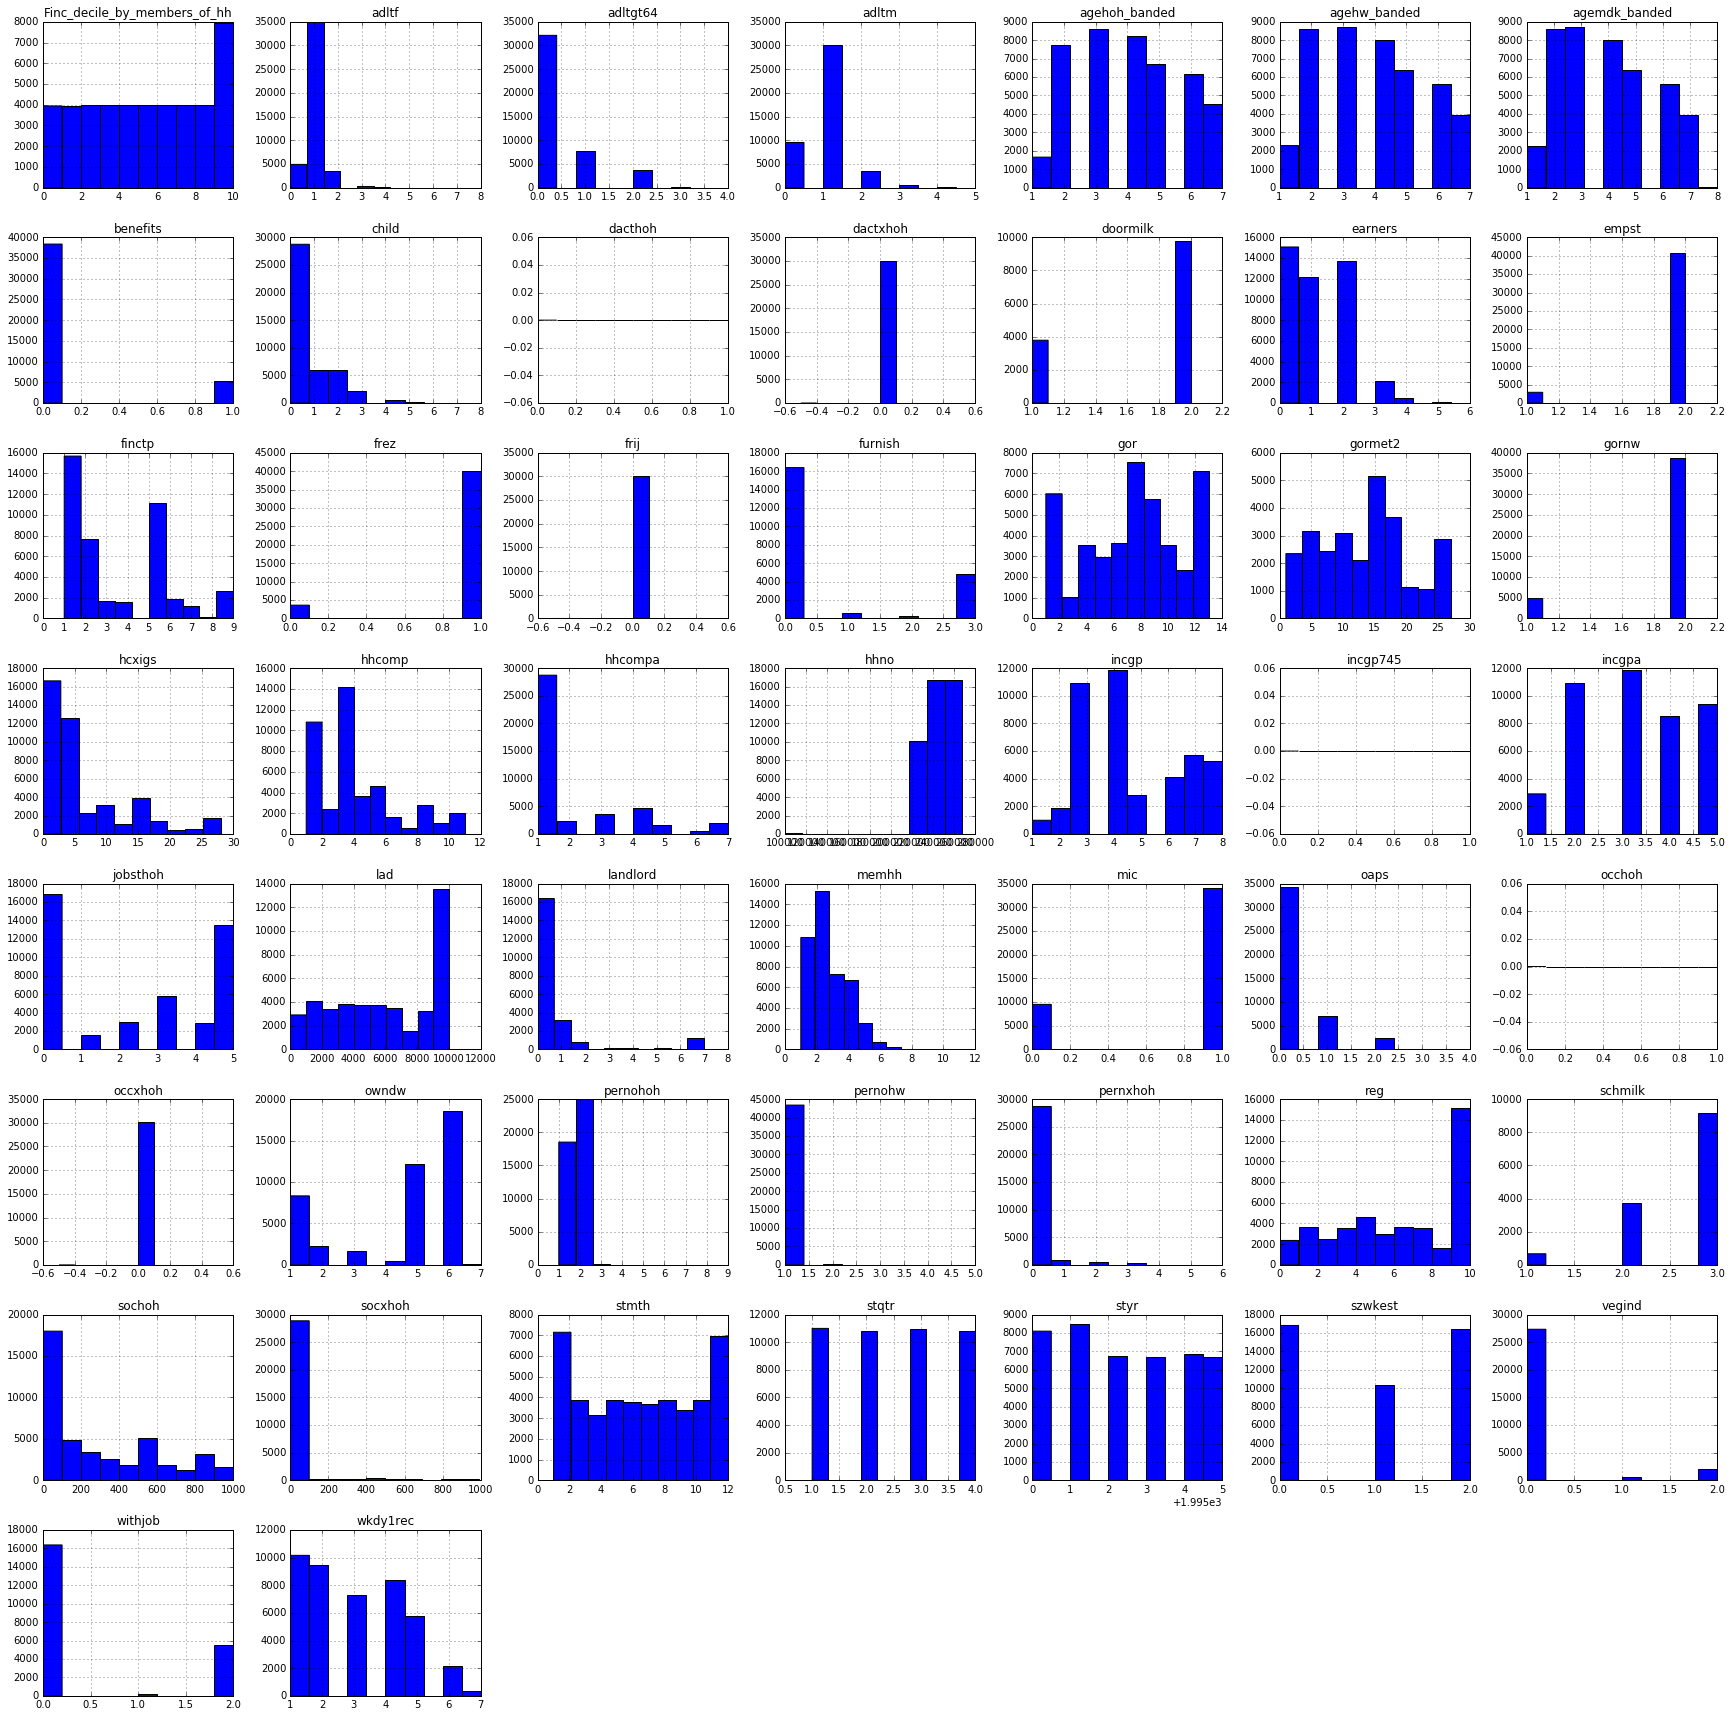

In [12]:
df = df_households
df.hist(figsize = (30,30))

In [13]:
df = df_households

#=== standard statistical region = 11 x (code, text); Scotland = 1
df_reg = pd.DataFrame.from_csv(dataRefe+'DCV_ Region.txt', sep='\t', index_col=None)
df_reg.columns=['reg', 'reg_text']
df2 = pd.merge(df, df_reg, how='left', on='reg')
print df2.reg_text.value_counts().sort_index()

EAST ANGLIA            1664
EAST MIDLANDS          2984
NORTH WEST             4602
NORTHERN               2453
NORTHERN IRELAND       3459
SCOTLAND               3682
SOUTH EAST            11670
SOUTH WEST             3546
WALES                  2359
WEST MIDLANDS          3667
YORKS & HUMBERSIDE     3538
Name: reg_text, dtype: int64


In [14]:
#=== income group of the head of the household = 8 categories --- I DON'T KNOW WHAT THEY MEAN
df_incgp = pd.DataFrame.from_csv(dataRefe+'DCV_ Income Group.txt', sep='\t', index_col=None)
df_incgp.columns=['incgp', 'income_group']
df2 = pd.merge(df, df_incgp, how='left', on='incgp')
print "\n", df2.income_group.value_counts().sort_index()


A1       991
A2      1909
B      10922
C      11885
D       2835
E1      4125
E2      5707
OAP     5250
Name: income_group, dtype: int64


In [15]:
#=== degree of activity of cross over head of household #sedentary etc --- THEY ARE ALL "OTHER"
df_dactxhoh = pd.DataFrame.from_csv(dataRefe+'DCV_ Degree of activity.txt', sep='\t', index_col=None)
df_dactxhoh.columns=['dactxhoh', 'degree_of_activity']
df2 = pd.merge(df, df_dactxhoh, how='left', on='dactxhoh')
print "\n", df2.degree_of_activity.value_counts().sort_index()


OTHER    30065
Name: degree_of_activity, dtype: int64


In [16]:
print "\nVegetarians? We don't know:\n", df.vegind.value_counts().sort_index()
print "\nIncome:\n", df.Finc_decile_by_members_of_hh.value_counts().sort_index()
print "\nFamily members:\n", df.memhh.value_counts().sort_index()


Vegetarians? We don't know:
0.0    27347
1.0      630
2.0     2088
Name: vegind, dtype: int64

Income:
0     3939
1     3948
2     3982
3     3961
4     3967
5     3971
6     3967
7     3978
8     3973
9     3969
10    3969
Name: Finc_decile_by_members_of_hh, dtype: int64

Family members:
1     10797
2     15250
3      7295
4      6706
5      2508
6       743
7       230
8        58
9        27
10       10
Name: memhh, dtype: int64



Children:
0    28733
1     5982
2     6043
3     2115
4      545
5      151
6       37
7       13
8        5
Name: child, dtype: int64


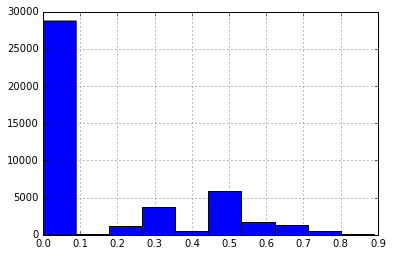

In [17]:
print "\nChildren:\n", df.child.value_counts().sort_index()
df2 = df
df2['propchild'] = df2.child / df2.memhh
df2.propchild.hist()


Elderly:
0    32139
1     7639
2     3801
3       41
4        4
Name: adltgt64, dtype: int64


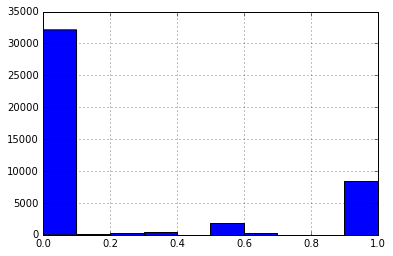

In [18]:
print "\nElderly:\n", df.adltgt64.value_counts().sort_index()
df2 = df
df2['propelderly'] = df2.adltgt64 / df2.memhh
df2.propelderly.hist() #most old people live without young people


Earners:
0    15062
1    12162
2    13694
3     2143
4      500
5       55
6        8
Name: earners, dtype: int64


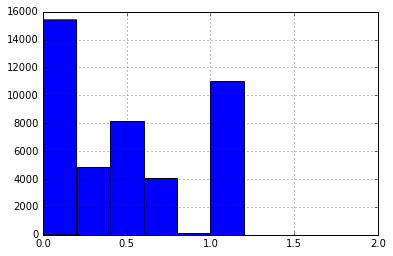

In [19]:
print "\nEarners:\n", df.earners.value_counts().sort_index()
df2 = df
df2['propearners'] = df2.earners / df2.memhh
df2.propearners.hist()

In [20]:
print "\nBenefits:\n", df.benefits.value_counts().sort_index()


Benefits:
0    38359
1     5265
Name: benefits, dtype: int64


In [21]:
#=== job status of head of household
df_jobsthoh = pd.DataFrame.from_csv(dataRefe+'DCV_ Job status of HOH.txt', sep='\t', index_col=None)
df_jobsthoh.columns = ['jobsthoh', 'job_status_hoh']
df2 = pd.merge(df, df_jobsthoh, how='left', on='jobsthoh')
print "\nJob status of hoh:\n", df2.job_status_hoh.value_counts().sort_index()


Job status of hoh:
APPRENTICES/EMPLOYEES NEC                13518
FOREMEN/SUPERVISORS                       2903
MANAGERS                                  5796
NOT APPLICABLE HOH UNEMPLOYED/RETIRED    16820
SELF EMPLOYED WITH EMPLOYEES              1606
SELF EMPLOYED WITHOUT EMPLOYEES           2981
Name: job_status_hoh, dtype: int64


In [22]:
#===size of work establishment of head of household #sme etc
df_szwkest = pd.DataFrame.from_csv(dataRefe+'DCV_ Size of work establishment.txt', sep='\t', index_col=None)
df_szwkest.columns=['szwkest', 'workplace']
df2 = pd.merge(df, df_szwkest, how='left', on='szwkest')
print "\nSize of workplace of hoh:\n", df2.workplace.value_counts().sort_index()


Size of workplace of hoh:
NOT APPLICABLE HOH UNEMPLOYED/RETIRED      16820
WORKS FOR ESTABLISHMENT OF 25 OR MORE      16445
WORKS FOR ESTABLISHMENT OF LESS THAN 25    10359
Name: workplace, dtype: int64


In [23]:
#=== tenure (ownership of dwelling) = 7 categories
df_owndw = pd.DataFrame.from_csv(dataRefe+'DCV_ Ownership of dwelling.txt', sep='\t', index_col=None)
df_owndw.columns=['owndw', 'ownhome']
df2 = pd.merge(df, df_owndw, how='left', on='owndw')
print "\nOwnership of dwelling:\n", df2.ownhome.value_counts().sort_index()


Ownership of dwelling:
FURNISHED, RENTED            1672
OWNS OUTRIGHT               12149
OWNS WITH MORTGAGE          18617
RENT FREE                     461
SHARED OWNERSHIP               93
UNFURNISHED COUNCIL          8325
UNFURNISHED,OTHER,RENTED     2307
Name: ownhome, dtype: int64


### Bring literals into the main file

In [24]:
#df_house_vars[df_house_vars.field.isin(selected_vars)]

In [25]:
df = df_households

#=== standard statistical region
df_reg = pd.DataFrame.from_csv(dataRefe+'DCV_ Region.txt', sep='\t', index_col=None)
df_reg.columns=['reg', 'reg_text']
df = pd.merge(df, df_reg, how='left', on='reg')

#=== income group of the head of the household
df_incgp = pd.DataFrame.from_csv(dataRefe+'DCV_ Income Group.txt', sep='\t', index_col=None)
df_incgp.columns=['incgp', 'income_group']
df = pd.merge(df, df_incgp, how='left', on='incgp')

#=== job status of head of household
df_jobsthoh = pd.DataFrame.from_csv(dataRefe+'DCV_ Job status of HOH.txt', sep='\t', index_col=None)
df_jobsthoh.columns = ['jobsthoh', 'job_status_hoh']
df = pd.merge(df, df_jobsthoh, how='left', on='jobsthoh')

#===size of work establishment of head of household
df_szwkest = pd.DataFrame.from_csv(dataRefe+'DCV_ Size of work establishment.txt', sep='\t', index_col=None)
df_szwkest.columns=['szwkest', 'workplace']
df = pd.merge(df, df_szwkest, how='left', on='szwkest')

#=== tenure (ownership of dwelling) = 7 categories
df_owndw = pd.DataFrame.from_csv(dataRefe+'DCV_ Ownership of dwelling.txt', sep='\t', index_col=None)
df_owndw.columns=['owndw', 'ownhome']
df = pd.merge(df, df_owndw, how='left', on='owndw')

df.drop(['gormet2', 'lad', 'styr', 'stmth', \
         'schmilk', 'occhoh', 'sochoh', 'finctp', 'pernohoh', 'pernohw', 'stqtr', 'gor', 'incgpa', \
         'hhcomp', 'hhcompa', 'hcxigs', 'dat1rec', 'doormilk', 'occxhoh', 'socxhoh',\
         'wkdy1rec', 'gornw', 'pernxhoh', 'incgp745', \
         'propchild', 'propelderly', 'propearners', \
         'reg', 'incgp', 'jobsthoh', 'szwkest', 'owndw'], inplace=True, axis=1)
df_households = df
df.head()

,hhno,mic,frez,memhh,dacthoh,Finc_decile_by_members_of_hh,agehoh_banded,agehw_banded,adltm,adltf,child,oaps,adltgt64,country,agemdk_banded,frij,earners,dactxhoh,empst,vegind,withjob,landlord,furnish,benefits,survyear,reg_text,income_group,job_status_hoh,workplace,ownhome
0,224203,1,1,3,NaN,10,4.0,4.0,1,1,1,0,0,Wales,4.0,0.0,1,0.0,2,0.0,NaN,NaN,NaN,0,1995,WALES,A1,SELF EMPLOYED WITH EMPLOYEES,WORKS FOR ESTABLISHMENT OF LESS THAN 25,OWNS WITH MORTGAGE
1,224204,1,1,1,NaN,0,3.0,3.0,1,0,0,0,0,Wales,3.0,0.0,1,0.0,2,2.0,NaN,NaN,NaN,0,1995,WALES,B,FOREMEN/SUPERVISORS,WORKS FOR ESTABLISHMENT OF LESS THAN 25,OWNS OUTRIGHT
2,224205,0,0,2,NaN,0,4.0,4.0,1,1,0,0,0,Wales,4.0,0.0,2,0.0,2,0.0,NaN,NaN,NaN,0,1995,WALES,C,APPRENTICES/EMPLOYEES NEC,WORKS FOR ESTABLISHMENT OF LESS THAN 25,OWNS OUTRIGHT
3,224206,1,1,2,NaN,0,5.0,5.0,1,1,0,0,0,Wales,5.0,0.0,2,0.0,2,0.0,NaN,NaN,NaN,0,1995,WALES,B,MANAGERS,WORKS FOR ESTABLISHMENT OF 25 OR MORE,OWNS OUTRIGHT
4,224207,1,0,1,NaN,1,7.0,7.0,0,1,0,1,1,Wales,7.0,0.0,0,0.0,2,0.0,NaN,NaN,NaN,0,1995,WALES,OAP,NOT APPLICABLE HOH UNEMPLOYED/RETIRED,NOT APPLICABLE HOH UNEMPLOYED/RETIRED,UNFURNISHED COUNCIL


## Weekly food-purchases per family

In [26]:
# ===== FOODS PER HOUSEHOLD =====
df = df_diary14
df_household_foods = pd.crosstab(df.hhno, df.minor_text, values = df.quantity, aggfunc=np.sum)
df_household_foods = df_household_foods.fillna(0)
df_household_foods.reset_index(level=0, inplace=True)
df = df_household_foods
#print "FOODS PER HOUSEHOLD: shape, number of variables, and variables:", \
#df.shape, len(df.columns), list(df.columns.values)

In [27]:
# ===== FOOD-GROUPS PER HOUSEHOLD =====
df = df_diary14[['hhno', 'quantity', 'group_text']]
df_household_groups = pd.crosstab(df.hhno, df.group_text, values = df.quantity, aggfunc=np.sum)
df_household_groups = df_household_groups.fillna(0)
df_household_groups.reset_index(level=0, inplace=True)
df = df_household_groups
#print "FOOD GROUP PER HOUSEHOLD: shape, number of variables, and variables:",\
#df.shape, len(df.columns), list(df.columns.values)

In [28]:
# ===== HOUSEHOLDS WITH THEIR FOOD-GROUPS =====
df = pd.merge(df_households, df_household_groups, how='left', on='hhno')
df_hh_with_food_groups = df
print "So we have {0:5} diary entries from {1:4} families".format(len(df_diary14), len(df_households))
print "and for each family we now have survyear + 50 (now less) demographic variables + 24 food-group variables."
#print "\nShape:", df.shape
#print "Number of variables:", len(df.columns)
#print "Variables:", list(df.columns.values)

So we have 1581381 diary entries from 43624 families
and for each family we now have survyear + 50 (now less) demographic variables + 24 food-group variables.


# 4. Logistic regression

For each household:
- a score of "good food", say dividing the amount of fruit per the amount of chocolate (or the other way round, depending who you ask!)
- and then a categorisation of that score, say stating that a score higher than 5 is good

### Good and bad food groups

I'm not a nutrition expert, but here's a rough idea of how I'd approach this:

- Low nutritional value: 'ALCOHOLIC DRINKS', 'ALL NON-CARCASE MEAT AND MEAT PRODUCTS', 'ALL OTHER FOODS', 'BEVERAGES', 'BISCUITS, CAKES, BUNS, CRISPBREADS', 'CONFECTIONERY', 'SOFT DRINKS', 'SUGAR AND PRESERVES'
- Some doubts: 'ALL BREAD' ("WHITE"?), 'CEREALS, EXCL. BREAD,BUNS,CAKES,BISCUITS'
- Generally good food: the rest

In [29]:
all_groups = df_grp_text.group_text.tolist()
#all_groups = df_groups.group_text.unique()

bad_groups = ['ALCOHOLIC DRINKS', 'ALL NON-CARCASE MEAT AND MEAT PRODUCTS', 'ALL OTHER FOODS', \
             'BEVERAGES', 'BISCUITS, CAKES, BUNS, CRISPBREADS', 'CONFECTIONERY', 'SOFT DRINKS', \
             'SUGAR AND PRESERVES']

good_groups = [x for x in all_groups if x not in bad_groups and x is not np.nan]
print "good groups:", good_groups
print "\nbad groups:", bad_groups

df = df_diary14[['hhno', 'quantity', 'group_text']]
df_good = df[df.group_text.isin(good_groups)]
df_bad = df[df.group_text.isin(bad_groups)]
#print "All food purchases split in good and bad:", len(df), len(df_good), len(df_bad)

good groups: ['LIQUID WHOLEMILK, INC SCHOOL & WELFARE', 'OTHER MILK & CREAM', 'TOTAL CHEESE', 'ALL CARCASE MEAT', 'ALL FISH', 'EGGS', 'ALL FATS', 'POTATOES', 'FRESH GREEN VEGETABLES', 'OTHER FRESH VEGETABLES', 'ALL PROCESSED VEGETABLES', 'FRESH FRUIT', 'FRUIT & FRUIT PRODS. NOT FRESH', 'ALL BREAD', 'FLOUR', 'CEREALS, EXCL. BREAD,BUNS,CAKES,BISCUITS']

bad groups: ['ALCOHOLIC DRINKS', 'ALL NON-CARCASE MEAT AND MEAT PRODUCTS', 'ALL OTHER FOODS', 'BEVERAGES', 'BISCUITS, CAKES, BUNS, CRISPBREADS', 'CONFECTIONERY', 'SOFT DRINKS', 'SUGAR AND PRESERVES']


### Use Quantities of food? No

In [30]:
# ===== SUM_GOOD = quantity of all good food groups, for each household

df = df_good
df_household_good_groups = pd.crosstab(df.hhno, df.group_text, values = df.quantity, aggfunc=np.sum)
df_household_good_groups = df_household_good_groups.fillna(0)
df_household_good_groups.reset_index(level=0, inplace=True)

df = df_household_good_groups
col_list= list(df)
col_list.remove('hhno')
df['sum_good'] = df[col_list].sum(axis=1)
df_household_good_groups = df

df = pd.merge(df_households, df_household_good_groups, how='left', on='hhno')
df_hh_with_good_food_groups = df
#print "GOOD: shape, number of variables, and variables:", df.shape, len(df.columns), list(df.columns.values)

In [31]:
# ===== SUM_BAD = idem for "not good" groups

df = df_bad
print df.shape
df_household_bad_groups = pd.crosstab(df.hhno, df.group_text, values = df.quantity, aggfunc=np.sum)
df_household_bad_groups = df_household_bad_groups.fillna(0)
df_household_bad_groups.reset_index(level=0, inplace=True)
df = df_household_bad_groups

col_list= list(df)
col_list.remove('hhno')
df['sum_bad'] = df[col_list].sum(axis=1) + 0.1 #in 24 cases it's zero, so maybe turn it into 0.1
df_household_bad_groups = df

df = pd.merge(df_households, df_household_bad_groups, how='left', on='hhno')
df_hh_with_bad_food_groups = df
#print "BAD: shape, number of variables, and variables:", df.shape, len(df.columns), list(df.columns.values)

(516188, 3)


**NOTE TO SELF: It would be much cleaner to merge the hh variables only when they are needed; i.e., later. But it's not a priority right now.**

In [32]:
df = pd.merge(df_households, df_household_good_groups, how='left', on='hhno')
df = pd.merge(df, df_household_bad_groups, how='left', on='hhno')
#len(df[df.how_good.isnull() == True]) #2315
df = df.fillna(1)
df['how_good'] = df['sum_good'] / (df['sum_bad'] + df['sum_good'])
df['how_bad'] = df['sum_bad'] / (df['sum_bad'] + df['sum_good'])
df_hh_with_all_food_groups = df
#print "So we have {0:5} diary entries from {1:4} families".format(len(df_diary14), len(df_households))
#print "and for each family we now have survyear + 53 demographical variables + 24 food-group variables"
#print "+ variables describing the goodness/badness of their shopping cart."
#print "Here's a sample:"
#df.head(3)

In [33]:
# Numerical comparison of the created variables

print df[['sum_good', 'sum_bad', 'how_good', 'how_bad']].describe()
print "SUM GOOD:",  len(df[df.sum_good == 0]), "are zero. ", len(df[df.sum_good == np.nan]), "are NaN."
print "SUM BAD:",   len(df[df.sum_bad == 0]),  "are zero. ", len(df[df.sum_bad == np.nan]),  "are NaN."
print "HOW GOOD: ", len(df[df.how_good == 0]), "are zero. ", len(df[df.how_good == np.nan]), "are NaN."
print "HOW BAD",    len(df[df.how_bad == 0]), " are zero. ", len(df[df.how_bad == np.nan]),  "are NaN."

           sum_good       sum_bad      how_good       how_bad
count  43624.000000  43624.000000  43624.000000  43624.000000
mean     457.767722    460.089837      0.569734      0.430266
std      359.387733    553.028197      0.217196      0.217196
min        0.220000      0.100000      0.001169      0.000099
25%      209.847500    107.450000      0.412579      0.264503
50%      396.275000    289.045000      0.569041      0.430959
75%      624.402500    621.312500      0.735497      0.587421
max    13930.670000  12785.340000      0.999901      0.998831
SUM GOOD: 0 are zero.  0 are NaN.
SUM BAD: 0 are zero.  0 are NaN.
HOW GOOD:  0 are zero.  0 are NaN.
HOW BAD 0  are zero.  0 are NaN.


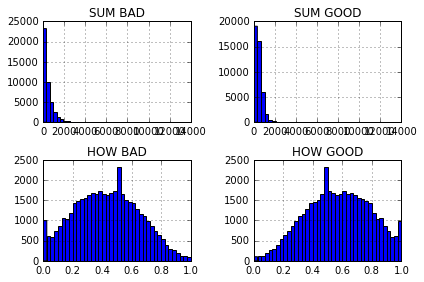

In [34]:
# Graphical comparison of the created variables
fig, axes = plt.subplots(nrows=2, ncols=2)
df.sum_bad.hist(ax=axes[0,0], bins = 40).set_title('SUM BAD')
df.sum_good.hist(ax=axes[0,1], bins = 40).set_title('SUM GOOD')
df.how_bad.hist(ax=axes[1,0], bins = 40).set_title('HOW BAD')
df.how_good.hist(ax=axes[1,1], bins = 40).set_title('HOW GOOD')
plt.tight_layout()

### Use Number of times each food is bought? Yes

In [35]:
# ===== ADD UP ALL TIMES EACH FOOD IS BOUGHT (EXCEPT HHNO) INTO SUM_GOOD

df = df_good
df_household_good_groups = pd.crosstab(df.hhno, df.group_text) #, values = df.quantity, aggfunc=np.sum
df_household_good_groups = df_household_good_groups.fillna(0)
df_household_good_groups.reset_index(level=0, inplace=True)

df = df_household_good_groups
col_list= list(df)
col_list.remove('hhno')
df['sum_good'] = df[col_list].sum(axis=1)
df_household_good_groups = df

df = pd.merge(df_households, df_household_good_groups, how='left', on='hhno')
df_hh_with_good_food_groups = df
#print "GOOD: shape, number of variables, and variables:", df.shape, len(df.columns), list(df.columns.values)

In [36]:
# ===== ADD UP ALL TIMES EACH FOOD IS BOUGHT (EXCEPT HHNO) INTO SUM_BAD

df = df_bad
print df.shape
df_household_bad_groups = pd.crosstab(df.hhno, df.group_text) #, values = df.quantity, aggfunc=np.sum
df_household_bad_groups = df_household_bad_groups.fillna(0)
df_household_bad_groups.reset_index(level=0, inplace=True)
df = df_household_bad_groups

col_list= list(df)
col_list.remove('hhno')
df['sum_bad'] = df[col_list].sum(axis=1) # + 0.1 #in 24 cases it's zero, so maybe turn it into 0.1
df_household_bad_groups = df

df = pd.merge(df_households, df_household_bad_groups, how='left', on='hhno')
df_hh_with_bad_food_groups = df
#print "BAD: shape, number of variables, and variables:", df.shape, len(df.columns), list(df.columns.values)

(516188, 3)


In [37]:
df = pd.merge(df_households, df_household_good_groups, how='left', on='hhno')
df = pd.merge(df, df_household_bad_groups, how='left', on='hhno')
#len(df[df.how_good.isnull() == True]) #2315
df = df.fillna(0.1)
df['how_good'] = df['sum_good'] / (df['sum_good'] + df['sum_bad'])
df['how_bad'] = df['sum_bad'] / (df['sum_good'] +  df['sum_bad'])
df_hh_with_all_food_groups = df
#print "So we have {0:5} diary entries from {1:4} families".format(len(df_diary14), len(df_households))
#print "and for each family we now have survyear + 53 demographical variables + 24 food-group variables"
#print "+ variables describing the goodness/badness of their shopping cart."
#print "Here's a sample:"
#df.head(3)

In [38]:
# Numerical comparison of the created variables

print df[['sum_good', 'sum_bad', 'how_good', 'how_bad']].describe()
print "SUM GOOD:",  len(df[df.sum_good == 0]), "are zero. ", len(df[df.sum_good == np.nan]), "are NaN."
print "SUM BAD:",   len(df[df.sum_bad == 0]),  "are zero. ", len(df[df.sum_bad == np.nan]),  "are NaN."
print "HOW GOOD: ", len(df[df.how_good == 0]), "are zero. ", len(df[df.how_good == np.nan]), "are NaN."
print "HOW BAD",    len(df[df.how_bad == 0]), " are zero. ", len(df[df.how_bad == np.nan]),  "are NaN."

           sum_good       sum_bad      how_good       how_bad
count  43624.000000  43624.000000  43624.000000  43624.000000
mean      24.419299     11.837782      0.685303      0.314697
std       14.102010      8.717686      0.132256      0.132256
min        0.100000      0.100000      0.012346      0.001883
25%       14.000000      5.000000      0.600000      0.232107
50%       23.000000     10.000000      0.683333      0.316667
75%       33.000000     17.000000      0.767893      0.400000
max      115.000000     92.000000      0.998117      0.987654
SUM GOOD: 0 are zero.  0 are NaN.
SUM BAD: 0 are zero.  0 are NaN.
HOW GOOD:  0 are zero.  0 are NaN.
HOW BAD 0  are zero.  0 are NaN.


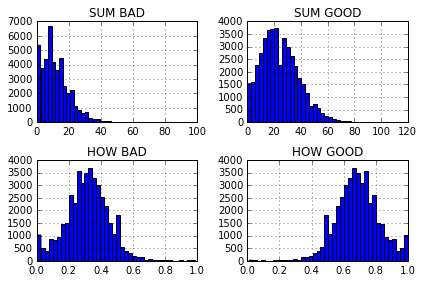

In [39]:
# Graphical comparison of the created variables
fig, axes = plt.subplots(nrows=2, ncols=2)
df.sum_bad.hist(ax=axes[0,0], bins = 40).set_title('SUM BAD')
df.sum_good.hist(ax=axes[0,1], bins = 40).set_title('SUM GOOD')
df.how_bad.hist(ax=axes[1,0], bins = 40).set_title('HOW BAD')
df.how_good.hist(ax=axes[1,1], bins = 40).set_title('HOW GOOD')
plt.tight_layout()

### Create categories ("good/bad cart") from "number of times each food was bought"

In [40]:
df = df_hh_with_all_food_groups
#df['good_cart'] = df.sum_good > 23 #median
df['good_cart'] = df.how_good > 0.683333  # > 0.767893 #=75% (0.683333 = 50% = median)
df.good_cart = df.good_cart.astype(int)
df_cat = df
print df_cat.good_cart.value_counts()
#df_cat[['hhno', 'sum_good', 'sum_bad', 'how_good', 'how_bad', 'good_cart']].head()

1    21828
0    21796
Name: good_cart, dtype: int64


## Promissing explanatory variables

### Numerical exploration

In [41]:
print "MEANS OF ALL HOUSEHOLD VARIABLES BY GOOD_CART:"
df_cat.groupby('good_cart').mean().transpose().head(23)

MEANS OF ALL HOUSEHOLD VARIABLES BY GOOD_CART:


good_cart,0,1
hhno,245957.098091,245953.868426
mic,0.803863,0.760262
frez,0.919756,0.914513
memhh,2.644109,2.372641
dacthoh,0.100000,0.100000
Finc_decile_by_members_of_hh,5.112360,4.898846
agehoh_banded,3.898229,4.258846
agehw_banded,3.732098,4.108448
adltm,0.927234,0.845428
adltf,0.982979,0.990975


In [42]:
df_cat.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
hhno,43624.0,245955.482074,1.289457e+04,100136.000000,235093.750000,246000.500000,256907.250000,267819.000000
mic,43624.0,0.782047,4.128603e-01,0.000000,1.000000,1.000000,1.000000,1.000000
frez,43624.0,0.917133,2.756846e-01,0.000000,1.000000,1.000000,1.000000,1.000000
memhh,43624.0,2.508275,1.336382e+00,1.000000,2.000000,2.000000,3.000000,10.000000
dacthoh,43624.0,0.100000,2.775589e-17,0.100000,0.100000,0.100000,0.100000,0.100000
Finc_decile_by_members_of_hh,43624.0,5.005524,3.160195e+00,0.000000,2.000000,5.000000,8.000000,10.000000
agehoh_banded,43624.0,4.078670,1.702887e+00,0.100000,3.000000,4.000000,5.000000,7.000000
agehw_banded,43624.0,3.920411,1.713561e+00,0.100000,2.000000,4.000000,5.000000,7.000000
adltm,43624.0,0.886301,5.838463e-01,0.000000,1.000000,1.000000,1.000000,5.000000
adltf,43624.0,0.986980,4.853634e-01,0.000000,1.000000,1.000000,1.000000,7.000000


### Graphic exploration

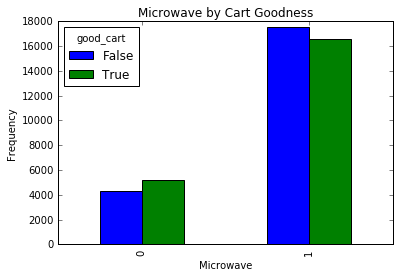

In [43]:
#Having a microwave seems to be associated with diet
pd.crosstab(df_cat.mic, df_cat.good_cart.astype(bool)).plot(kind='bar')
plt.title('Microwave by Cart Goodness')
plt.xlabel('Microwave')
plt.ylabel('Frequency')

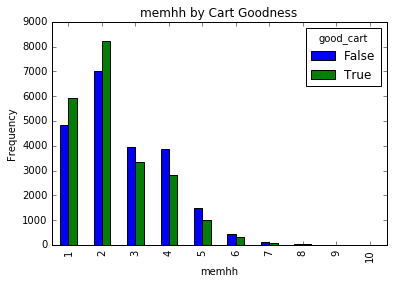

In [44]:
#Larger memhh seems to be associated with diet
pd.crosstab(df_cat.memhh, df_cat.good_cart.astype(bool)).plot(kind='bar')
plt.title('memhh by Cart Goodness')
plt.xlabel('memhh')
plt.ylabel('Frequency')

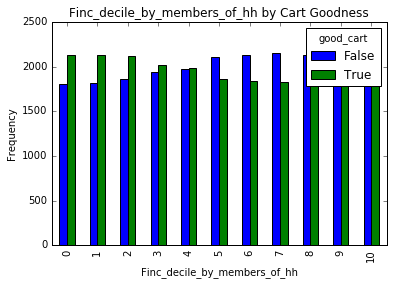

In [45]:
#Finc_decile_by_members_of_hh seems to be associated with diet
pd.crosstab(df_cat.Finc_decile_by_members_of_hh, df_cat.good_cart.astype(bool)).plot(kind='bar')
plt.title('Finc_decile_by_members_of_hh by Cart Goodness')
plt.xlabel('Finc_decile_by_members_of_hh')
plt.ylabel('Frequency')

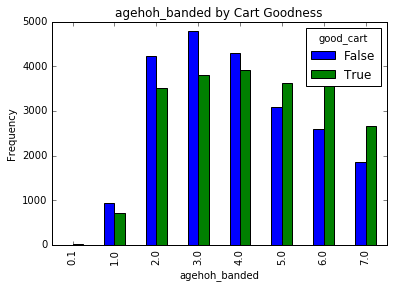

In [46]:
#agehoh_banded seems to be associated with diet
pd.crosstab(df_cat.agehoh_banded, df_cat.good_cart.astype(bool)).plot(kind='bar')
plt.title('agehoh_banded by Cart Goodness')
plt.xlabel('agehoh_banded')
plt.ylabel('Frequency')

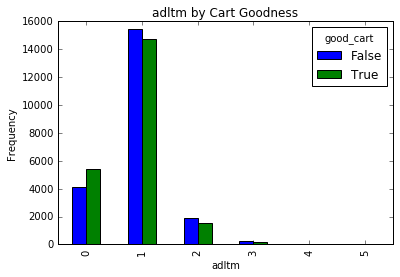

In [47]:
#adltm seems to be associated with diet
pd.crosstab(df_cat.adltm, df_cat.good_cart.astype(bool)).plot(kind='bar')
plt.title('adltm by Cart Goodness')
plt.xlabel('adltm')
plt.ylabel('Frequency')

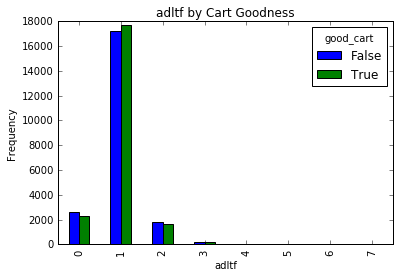

In [48]:
#adltf seems to be associated with diet
pd.crosstab(df_cat.adltf, df_cat.good_cart.astype(bool)).plot(kind='bar')
plt.title('adltf by Cart Goodness')
plt.xlabel('adltf')
plt.ylabel('Frequency')

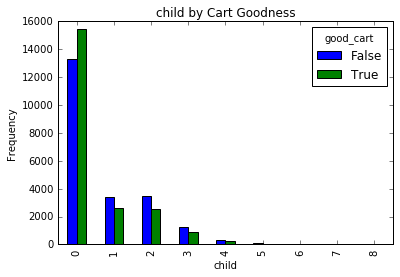

In [49]:
#child seems to be associated with diet
pd.crosstab(df_cat.child, df_cat.good_cart.astype(bool)).plot(kind='bar')
plt.title('child by Cart Goodness')
plt.xlabel('child')
plt.ylabel('Frequency')

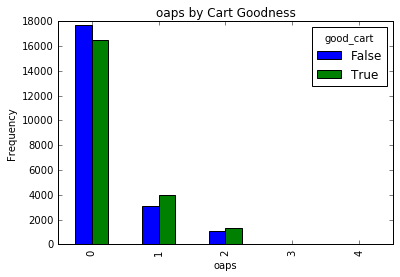

In [50]:
#oaps seems to be associated with diet
pd.crosstab(df_cat.oaps, df_cat.good_cart.astype(bool)).plot(kind='bar')
plt.title('oaps by Cart Goodness')
plt.xlabel('oaps')
plt.ylabel('Frequency')

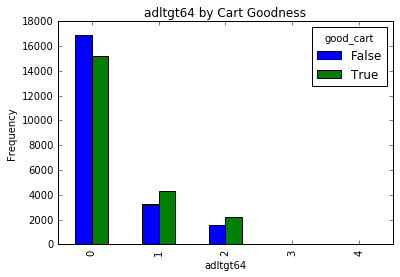

In [51]:
#adltgt64 seems to be associated with diet
pd.crosstab(df_cat.adltgt64, df_cat.good_cart.astype(bool)).plot(kind='bar')
plt.title('adltgt64 by Cart Goodness')
plt.xlabel('adltgt64')
plt.ylabel('Frequency')

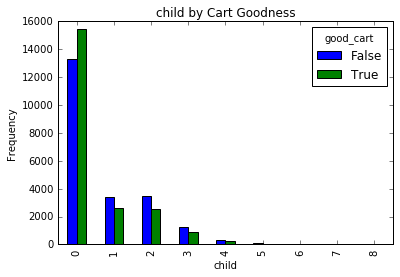

In [52]:
#child seems to be associated with diet
pd.crosstab(df_cat.child, df_cat.good_cart.astype(bool)).plot(kind='bar')
plt.title('child by Cart Goodness')
plt.xlabel('child')
plt.ylabel('Frequency')

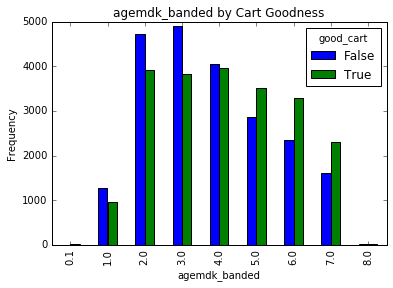

In [53]:
#agemdk_banded seems to be associated with diet
pd.crosstab(df_cat.agemdk_banded, df_cat.good_cart.astype(bool)).plot(kind='bar')
plt.title('agemdk_banded by Cart Goodness')
plt.xlabel('agemdk_banded')
plt.ylabel('Frequency')

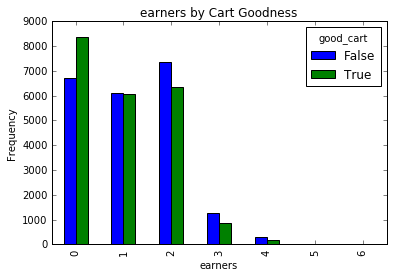

In [54]:
#earners seems to be associated with diet
pd.crosstab(df_cat.earners, df_cat.good_cart.astype(bool)).plot(kind='bar')
plt.title('earners by Cart Goodness')
plt.xlabel('earners')
plt.ylabel('Frequency')

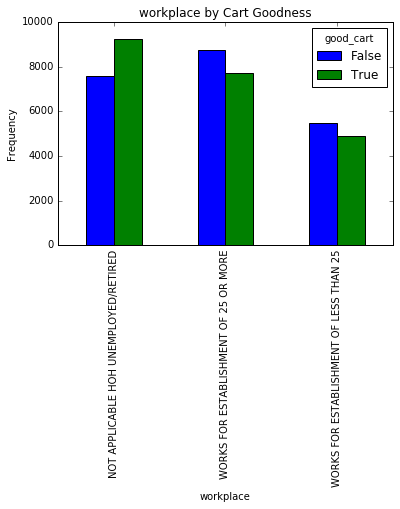

In [55]:
#workplace seems to be associated with diet
pd.crosstab(df_cat.workplace, df_cat.good_cart.astype(bool)).plot(kind='bar')
plt.title('workplace by Cart Goodness')
plt.xlabel('workplace')
plt.ylabel('Frequency')

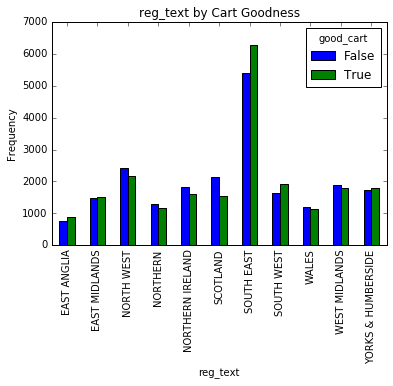

In [56]:
#reg_text seems to be associated with diet
pd.crosstab(df_cat.reg_text, df_cat.good_cart.astype(bool)).plot(kind='bar')
plt.title('reg_text by Cart Goodness')
plt.xlabel('reg_text')
plt.ylabel('Frequency')

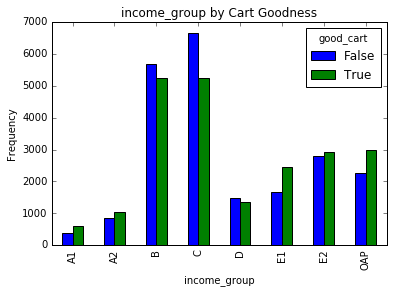

In [57]:
#income_group seems to be associated with diet
pd.crosstab(df_cat.income_group, df_cat.good_cart.astype(bool)).plot(kind='bar')
plt.title('income_group by Cart Goodness')
plt.xlabel('income_group')
plt.ylabel('Frequency')

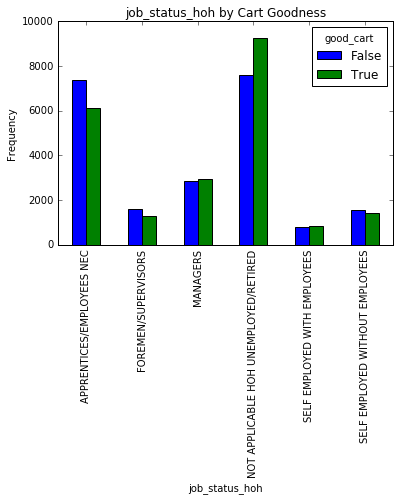

In [58]:
#job_status_hoh seems to be associated with diet
pd.crosstab(df_cat.job_status_hoh, df_cat.good_cart.astype(bool)).plot(kind='bar')
plt.title('job_status_hoh by Cart Goodness')
plt.xlabel('job_status_hoh')
plt.ylabel('Frequency')

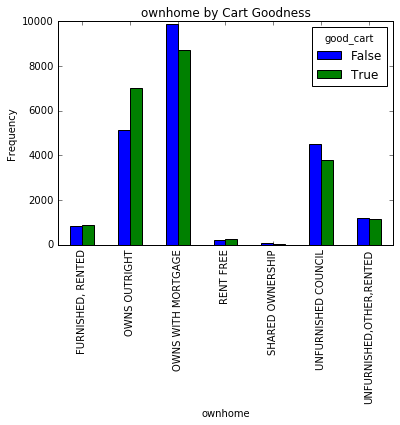

In [59]:
#ownhome seems to be associated with diet
pd.crosstab(df_cat.ownhome, df_cat.good_cart.astype(bool)).plot(kind='bar')
plt.title('ownhome by Cart Goodness')
plt.xlabel('ownhome')
plt.ylabel('Frequency')

## Prepare data for LR model

This includes:
- Selecting variables: identifier for each family, pre-selected demographic variables, and outcome variable ("good_cart")
- Renaming variables so that they are easier to understand when looking at the results
- Creating the matrices (and maybe renaming the ugly variables)
- Flattening the y matrix

In [60]:
#df_cat.columns
df = df_cat
df = df[['hhno', 'mic', 'frez', 'memhh', 'Finc_decile_by_members_of_hh', 'agehoh_banded', \
                 'agehw_banded', 'adltm', 'adltf', 'child', 'oaps', 'adltgt64', 'country', 'agemdk_banded',\
                 'frij', 'earners', 'vegind', 'withjob', 'landlord', 'furnish', 'benefits', 'survyear',\
                 'reg_text', 'income_group', 'job_status_hoh', 'workplace', 'ownhome', 'good_cart']]
df.columns = ['hhno', 'micro', 'freez', 'people', 'income', 'age_head', 'age_hwife', 'males', 'females',\
                  'children', 'oaps', 'seniors', 'country', 'age_reporter', 'fridge', 'earners', 'veget', \
                  'withjob', 'landlord', 'furnish', 'benefits', 'survyear', 'region', 'income_group', \
                  'job_status', 'workplace', 'own_home', 'good_cart']
df = df[['hhno', 'good_cart', \
                 'veget', \
                 'micro', 'freez', 'fridge', 'own_home', 'landlord', 'furnish', \
                 'people', 'males', 'females', 'children', 'oaps', 'seniors', 'earners', \
                 'age_head', 'age_hwife', 'age_reporter', \
                 'income', 'income_group', 'benefits', 'workplace', 'job_status', 'withjob', \
                 'country', 'region', 'survyear']]
df_clean = df
df.head()

,hhno,good_cart,veget,micro,freez,fridge,own_home,landlord,furnish,people,males,females,children,oaps,seniors,earners,age_head,age_hwife,age_reporter,income,income_group,benefits,workplace,job_status,withjob,country,region,survyear
0,224203,1,0.0,1,1,0.0,OWNS WITH MORTGAGE,0.1,0.1,3,1,1,1,0,0,1,4.0,4.0,4.0,10,A1,0,WORKS FOR ESTABLISHMENT OF LESS THAN 25,SELF EMPLOYED WITH EMPLOYEES,0.1,Wales,WALES,1995
1,224204,0,2.0,1,1,0.0,OWNS OUTRIGHT,0.1,0.1,1,1,0,0,0,0,1,3.0,3.0,3.0,0,B,0,WORKS FOR ESTABLISHMENT OF LESS THAN 25,FOREMEN/SUPERVISORS,0.1,Wales,WALES,1995
2,224205,1,0.0,0,0,0.0,OWNS OUTRIGHT,0.1,0.1,2,1,1,0,0,0,2,4.0,4.0,4.0,0,C,0,WORKS FOR ESTABLISHMENT OF LESS THAN 25,APPRENTICES/EMPLOYEES NEC,0.1,Wales,WALES,1995
3,224206,1,0.0,1,1,0.0,OWNS OUTRIGHT,0.1,0.1,2,1,1,0,0,0,2,5.0,5.0,5.0,0,B,0,WORKS FOR ESTABLISHMENT OF 25 OR MORE,MANAGERS,0.1,Wales,WALES,1995
4,224207,0,0.0,1,0,0.0,UNFURNISHED COUNCIL,0.1,0.1,1,0,1,0,1,1,0,7.0,7.0,7.0,1,OAP,0,NOT APPLICABLE HOH UNEMPLOYED/RETIRED,NOT APPLICABLE HOH UNEMPLOYED/RETIRED,0.1,Wales,WALES,1995


In [61]:
from patsy import dmatrices

y, X = dmatrices('good_cart ~ veget + micro + freez + fridge + own_home + landlord + furnish + \
                  people + males + females + children + oaps + seniors + earners + \
                  age_head + age_hwife + age_reporter + \
                  income + income_group + benefits + workplace + job_status + withjob + \
                  country + region + survyear', df, return_type="dataframe")

#print X.columns
X.head()

,Intercept,own_home[T.OWNS OUTRIGHT],own_home[T.OWNS WITH MORTGAGE],own_home[T.RENT FREE],own_home[T.SHARED OWNERSHIP],own_home[T.UNFURNISHED COUNCIL],"own_home[T.UNFURNISHED,OTHER,RENTED]",income_group[T.A2],income_group[T.B],income_group[T.C],income_group[T.D],income_group[T.E1],income_group[T.E2],income_group[T.OAP],workplace[T.WORKS FOR ESTABLISHMENT OF 25 OR MORE],workplace[T.WORKS FOR ESTABLISHMENT OF LESS THAN 25],job_status[T.FOREMEN/SUPERVISORS],job_status[T.MANAGERS],job_status[T.NOT APPLICABLE HOH UNEMPLOYED/RETIRED],job_status[T.SELF EMPLOYED WITH EMPLOYEES],job_status[T.SELF EMPLOYED WITHOUT EMPLOYEES],country[T.N Ireland],country[T.Scotland],country[T.Wales],region[T.EAST MIDLANDS],region[T.NORTH WEST],region[T.NORTHERN],region[T.NORTHERN IRELAND],region[T.SCOTLAND],region[T.SOUTH EAST],region[T.SOUTH WEST],region[T.WALES],region[T.WEST MIDLANDS],region[T.YORKS & HUMBERSIDE],survyear[T.1996],survyear[T.1997],survyear[T.1998],survyear[T.1999],survyear[T.2000],veget,micro,freez,fridge,landlord,furnish,people,males,females,children,oaps,seniors,earners,age_head,age_hwife,age_reporter,income,benefits,withjob
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.1,0.1,3.0,1.0,1.0,1.0,0.0,0.0,1.0,4.0,4.0,4.0,10.0,0.0,0.1
1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.1,0.1,1.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,3.0,3.0,0.0,0.0,0.1
2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.1,2.0,1.0,1.0,0.0,0.0,0.0,2.0,4.0,4.0,4.0,0.0,0.0,0.1
3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.1,0.1,2.0,1.0,1.0,0.0,0.0,0.0,2.0,5.0,5.0,5.0,0.0,0.0,0.1
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.1,0.1,1.0,0.0,1.0,0.0,1.0,1.0,0.0,7.0,7.0,7.0,1.0,0.0,0.1


In [62]:
# fix column names of X
#X = X.rename(columns = {'C(own_home)[T.OWNS OUTRIGHT]':'own_home_outright',
#                        'C(own_home)[T.OWNS WITH MORTGAGE]':'own_home_mortgage'})
#lots of work: would do it if i had more time

In [63]:
y.head()

,good_cart
0,1.0
1,0.0
2,1.0
3,1.0
4,0.0


In [64]:
# flatten y into a 1-D array
y = np.ravel(y)
print y

[ 1.  0.  1. ...,  1.  1.  1.]


In [65]:
print X.shape
print y.shape

(43624, 58)
(43624,)


## Run LR model on whole dataset

In [66]:
# instanciate a logistic regression model, and fit with X and y
model = LogisticRegression()
model = model.fit(X, y)
model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

## Check results

In [67]:
# check the accuracy (on the training set ?)
model.score(X, y)

0.58791032459196768

In [68]:
y.mean()

0.50036677058499912

**^ Question:**
- Accuracy is 0.57633412800293415 with HOW_GOOD = median
- and 0.75958188153310102  with HOW_GOOD = percentile 75.
- So it looks as if the model is only slightly better than predicting at random (which is what we would do if we used the mean of 0.50036677058499912)?

## Examine coefficients

In [69]:
# examine the coefficients --- SORTED BY VARIABLE
pd.DataFrame(zip(X.columns, np.transpose(model.coef_)))

,0,1
0,Intercept,[0.182404944244]
1,own_home[T.OWNS OUTRIGHT],[0.170203577427]
2,own_home[T.OWNS WITH MORTGAGE],[0.0407856894566]
3,own_home[T.RENT FREE],[0.266051314532]
4,own_home[T.SHARED OWNERSHIP],[0.0154927547754]
5,own_home[T.UNFURNISHED COUNCIL],[-0.133478407234]
6,"own_home[T.UNFURNISHED,OTHER,RENTED]",[-0.0251331115864]
7,income_group[T.A2],[-0.191082134529]
8,income_group[T.B],[-0.406875024799]
9,income_group[T.C],[-0.564098876506]


In [70]:
# examine the coefficients --- SORTED BY VALUE OF THE COEFFICIENTS
df_coef = pd.DataFrame(zip(X.columns, np.transpose(model.coef_)))
df_coef.sort_values(1)

,0,1
13,income_group[T.OAP],[-0.62511379448]
12,income_group[T.E2],[-0.620779158886]
9,income_group[T.C],[-0.564098876506]
11,income_group[T.E1],[-0.522477516312]
10,income_group[T.D],[-0.51170767156]
8,income_group[T.B],[-0.406875024799]
25,region[T.NORTH WEST],[-0.218531690972]
22,country[T.Scotland],[-0.215919035393]
28,region[T.SCOTLAND],[-0.215919035393]
26,region[T.NORTHERN],[-0.206292400665]


**^ QUESTION: Does the (absolute) size of the coefficient matter for variable selection?**

If "YES", then I'd select income_group, region, veget, own_home

In [71]:
print "MEANS of all variables (first 52, then 28), by GOOD_CART:"
df.groupby('good_cart').mean().transpose().head(52)

MEANS of all variables (first 52, then 28), by GOOD_CART:


good_cart,0,1
hhno,245957.098091,245953.868426
veget,0.094531,0.187901
micro,0.803863,0.760262
freez,0.919756,0.914513
fridge,0.031033,0.031130
landlord,0.404822,0.406061
furnish,0.429138,0.390851
people,2.644109,2.372641
males,0.927234,0.845428
females,0.982979,0.990975


**^ QUESTION: How to select variables that add most to the model?**

## Cross-validation

In [72]:
df = df_clean
df.head()

,hhno,good_cart,veget,micro,freez,fridge,own_home,landlord,furnish,people,males,females,children,oaps,seniors,earners,age_head,age_hwife,age_reporter,income,income_group,benefits,workplace,job_status,withjob,country,region,survyear
0,224203,1,0.0,1,1,0.0,OWNS WITH MORTGAGE,0.1,0.1,3,1,1,1,0,0,1,4.0,4.0,4.0,10,A1,0,WORKS FOR ESTABLISHMENT OF LESS THAN 25,SELF EMPLOYED WITH EMPLOYEES,0.1,Wales,WALES,1995
1,224204,0,2.0,1,1,0.0,OWNS OUTRIGHT,0.1,0.1,1,1,0,0,0,0,1,3.0,3.0,3.0,0,B,0,WORKS FOR ESTABLISHMENT OF LESS THAN 25,FOREMEN/SUPERVISORS,0.1,Wales,WALES,1995
2,224205,1,0.0,0,0,0.0,OWNS OUTRIGHT,0.1,0.1,2,1,1,0,0,0,2,4.0,4.0,4.0,0,C,0,WORKS FOR ESTABLISHMENT OF LESS THAN 25,APPRENTICES/EMPLOYEES NEC,0.1,Wales,WALES,1995
3,224206,1,0.0,1,1,0.0,OWNS OUTRIGHT,0.1,0.1,2,1,1,0,0,0,2,5.0,5.0,5.0,0,B,0,WORKS FOR ESTABLISHMENT OF 25 OR MORE,MANAGERS,0.1,Wales,WALES,1995
4,224207,0,0.0,1,0,0.0,UNFURNISHED COUNCIL,0.1,0.1,1,0,1,0,1,1,0,7.0,7.0,7.0,1,OAP,0,NOT APPLICABLE HOH UNEMPLOYED/RETIRED,NOT APPLICABLE HOH UNEMPLOYED/RETIRED,0.1,Wales,WALES,1995


## Evaluate model splitting data into training set and testing set

In [73]:
# split
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
model2 = LogisticRegression()
model2.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [74]:
print "- The 'train' set has ", len(X_train), "observations."
print "- The 'test' set has  ", len(X_test), "observations."

- The 'train' set has  30536 observations.
- The 'test' set has   13088 observations.


In [75]:
# predict
predicted = model2.predict(X_test)
print predicted
print predicted.shape

[ 0.  0.  1. ...,  0.  0.  1.]
(13088,)


In [76]:
# generate class probabilities   ----- I DON'T UNDERSTAND THE OUTCOME OF THIS
probs = model2.predict_proba(X_test)
print probs

[[ 0.63931134  0.36068866]
 [ 0.53610321  0.46389679]
 [ 0.39111709  0.60888291]
 ..., 
 [ 0.58182323  0.41817677]
 [ 0.58247322  0.41752678]
 [ 0.43987786  0.56012214]]


In [77]:
# generate evaluation metrics
print metrics.accuracy_score(y_test, predicted)
print metrics.roc_auc_score(y_test, probs[:, 1])

0.580302567237
0.611235262522


In [78]:
# see the confusion matrix and a classification report with other metrics
print metrics.confusion_matrix(y_test, predicted)
print metrics.classification_report(y_test, predicted)

[[3968 2611]
 [2882 3627]]
             precision    recall  f1-score   support

        0.0       0.58      0.60      0.59      6579
        1.0       0.58      0.56      0.57      6509

avg / total       0.58      0.58      0.58     13088



## Evaluate model with cross-validation

In [79]:
# 10-fold cross-validation
scores = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10)
print scores
print scores.mean()

[ 0.57689663  0.61425625  0.57987623  0.59294064  0.59660784  0.56566583
  0.57771664  0.56189821  0.57647329  0.57119927]
0.581353081824


## Predicting probability for a combination of variables

In [80]:
#model.predict_proba(np.array([1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 3, 25, 3, 1, 4,
#                              16]))

# 5. Discussion

## Work done

- I've downloaded open data from a survey of UK families over a number of years.
- I've put the files together, and created two variables:
    - how_good: sum_good / (sum_good + sum_bad)
    - good_cart: 1 if how_good > median
- I've created a LR model:
    - first with the full dataset
    - second splitting into subsets: training and testing
    - third splitting into 10 subsets (crossvalidation)

## Main findings

- The model predicts only a bit better than throwing a dice
- I don't know how to select better variables for the model

## Limitations

- The data is what it is
- I selected food groups for practical reasons, knowing that they don't define a good diet

## Lessons learned

- EDA really has to be done at the beginning, not half-way through the project

## What next

- Let's see if I can refine the questions for my mentor

# 6. Further code

In [81]:
'''
Further code from other examples and exercises --- I don't know if I should use any of this:

#TRAIN THE MODEL

from sklearn.cross_validation import KFold
from sklearn.metrics import accuracy_score

def cv_score(clf, x, y, score_func=accuracy_score):
    result = 0
    nfold = 5
    for train, test in KFold(y.size, nfold): # split data into train/test groups, 5 times
        clf.fit(x[train], y[train]) # fit
        result += score_func(clf.predict(x[test]), y[test]) # evaluate score function on held-out data
    return result / nfold # average

from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(Xlr,ylr)
print "accuracy with test data:", accuracy_score(clf.predict(Xtestlr),ytestlr)

clf = LogisticRegression()
score = cv_score(clf, Xlr, ylr)
print "score with train data:", score

Cs = [0.001, 0.1, 1, 10, 100]
for c in Cs:
    clf = LogisticRegression(C=c)
    clf.fit(Xlr,ylr)
    score = accuracy_score(clf.predict(Xlr),ylr)
    print "C and score: ", c, score
print "(select C with maximum score, i.e. C=...)"

clf = LogisticRegression(C=0.001)
clf.fit(Xlr, ylr)
accuracy = accuracy_score(clf.predict(Xtestlr), ytestlr)
print "Accuracy with test-data:", accuracy

from sklearn import grid_search
clf = grid_search.GridSearchCV(LogisticRegression(C=1), param_grid = {'C':[0.001, 0.1, 1, 10, 100]})
clf.fit(Xlr, ylr)
print "best parameter:", clf.best_params_
print "with a score of:", clf.best_score_
print "From this grid of scores:"
clf.grid_scores_

accuracy = accuracy_score(clf.predict(Xtestlr), ytestlr)
print("Accuracy: %f" % accuracy)
'''

'\nFurther code from other examples and exercises --- I don\'t know if I should use any of this:\n\n#TRAIN THE MODEL\n\nfrom sklearn.cross_validation import KFold\nfrom sklearn.metrics import accuracy_score\n\ndef cv_score(clf, x, y, score_func=accuracy_score):\n    result = 0\n    nfold = 5\n    for train, test in KFold(y.size, nfold): # split data into train/test groups, 5 times\n        clf.fit(x[train], y[train]) # fit\n        result += score_func(clf.predict(x[test]), y[test]) # evaluate score function on held-out data\n    return result / nfold # average\n\nfrom sklearn.linear_model import LogisticRegression\nclf = LogisticRegression()\nclf.fit(Xlr,ylr)\nprint "accuracy with test data:", accuracy_score(clf.predict(Xtestlr),ytestlr)\n\nclf = LogisticRegression()\nscore = cv_score(clf, Xlr, ylr)\nprint "score with train data:", score\n\nCs = [0.001, 0.1, 1, 10, 100]\nfor c in Cs:\n    clf = LogisticRegression(C=c)\n    clf.fit(Xlr,ylr)\n    score = accuracy_score(clf.predict(Xlr),